In [10]:
import pickle
import numpy as np
import pandas as pd
import networkx as nx

In [11]:
G_train = nx.read_edgelist('t3-train.txt', create_using=nx.DiGraph(), nodetype=int, edgetype=int)
unG_train = nx.read_edgelist('t3-train.txt', create_using=nx.Graph(), nodetype=int, edgetype=int)
print(len(G_train.edges), 'edges')
print(len(G_train.nodes), 'nodes')

86381 edges
12480 nodes


In [12]:
G_test = nx.read_edgelist('t3-test.txt', create_using=nx.DiGraph(), nodetype=int, edgetype=int)
unG_test = nx.read_edgelist('t3-test.txt', create_using=nx.Graph(), nodetype=int, edgetype=int)
print(len(G_test.edges), 'edges')
print(len(G_test.nodes), 'nodes')

test_x = []
for fromId, toId in np.loadtxt('t3-test.txt'):
    test_x.append((fromId,  toId))
test_x = np.array(test_x).astype('int64')

74798 edges
10563 nodes


In [13]:
with open('nodeMeta.pkl', 'rb') as f:
    nodeMeta = pickle.load(f)

In [14]:
nodes = list(G_train.nodes)
emb = []
trans = dict()
for e, i in enumerate(G_train.nodes):
    t = nodeMeta[i]["tvec"]
    a = nodeMeta[i]["avec"]
    tmp = np.hstack([t, a])
    emb.append(tmp)
    trans[i] = e
    
emb = np.array(emb)
emb.shape

(12480, 800)

In [15]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors()
neigh.fit(emb)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [16]:
X, Y = [], []
size = []

for e, node in enumerate(G_train.nodes):
    node_emb = emb[trans[node]].reshape(1, -1)
    pos_nodes = set(G_train.successors(node))
    test_nodes = set(G_test.successors(node)) if node in G_test.nodes else set()
    
    
    # 4 step bfs
    #'''
    neg_nodes = set()
    cand = [node]
    for _ in range(4):
        new = set()
        for i in cand:
            tmp = set(G_train.successors(i))
            new = new | tmp
        new = new - neg_nodes - set([node])
        neg_nodes = neg_nodes | new
        cand = list(new)
    
    neg_nodes = neg_nodes - pos_nodes - test_nodes - set([node])
    neg_samples = np.random.choice(list(neg_nodes), int(len(pos_nodes) * 1)) if neg_nodes else []
    size.append(len(neg_nodes))
    #'''
    
    # high similarity
    '''
    neg_nodes = set(G_train.nodes) - pos_nodes - test_nodes - set([node])
    idx = neigh.kneighbors(node_emb, len(G_train.nodes), return_distance=False)[0][:17500//4]
    neg_samples = np.random.choice(idx, int(len(pos_nodes) * 1)) if neg_nodes else []
    neg_samples = [nodes[i] for i in neg_samples]
#     neg_samples = []
#     for i in idx:
#         if nodes[i] in neg_nodes:
#             neg_samples.append(nodes[i])
#         if len(neg_samples) >= len(pos_nodes):
#             break
    '''
    

    for pos in pos_nodes:
        X.append((node, pos))
        Y.append(1)

    for neg in neg_samples:
        X.append((node, neg))
        Y.append(0)

    print(np.round(e/len(G_train), 2), end='\r')
print("100%")
print(len(X), len(Y))

100%
169941 169941


In [17]:
print(len(X), len(Y))
X = np.array(X)
Y = np.array(Y)

df = pd.DataFrame()
df['head'] = X[:, 0]
df['tail'] = X[:, 1]
df['label'] = Y[:, 0]

prefix = "4step_"
df.to_csv(prefix+"sample.csv", index=False)

169941 169941
Stored 'X2' (list)
Stored 'Y2' (list)


9.0
44.25064102564102


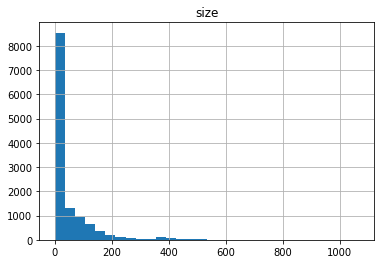

In [9]:
%matplotlib inline
df = pd.DataFrame()
df['size'] = size
df.hist(bins=30)
print(np.median(size))
print(np.mean(size))